In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt




In [4]:
def show(data, const_axis, const_val, x_axis, y_axis, z_axis, colour="gray", z_min=-2, z_max=2, title=None):
    data = data.loc[data[const_axis] == const_val]
    data = data.pivot(columns=x_axis, index=y_axis, values=z_axis)
    fig, ax = plt.subplots()
    ax.imshow(data, cmap=colour, vmin=z_min, vmax=z_max)    

    plt.title(title)
    plt.tight_layout()
    return plt.show(fig)

In [5]:
full_data = pd.read_parquet("Sleipner_4D_Seismic_Small.parquet.gzip", engine = "pyarrow")
# Calculate differences
full_data['01-94'] = full_data['01'] - full_data['94']
full_data['06-01'] = full_data['06'] - full_data['01']
full_data['06-94'] = full_data['06'] - full_data['94']


Analyzing year range: 01-94


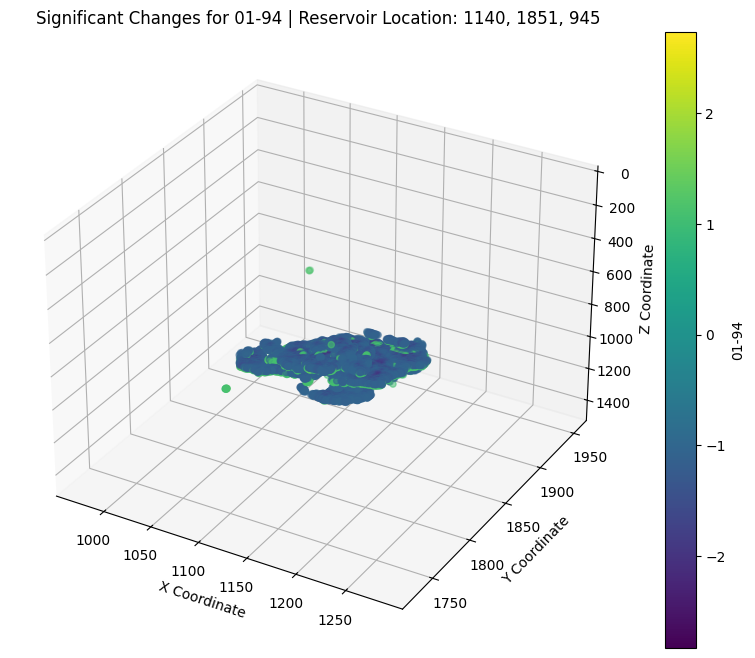

Analyzing year range: 06-01


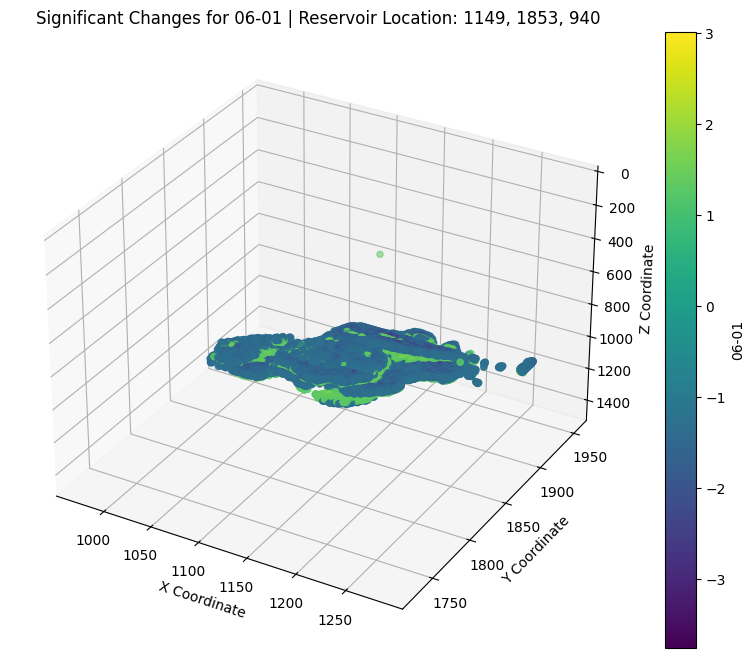

Analyzing year range: 06-94


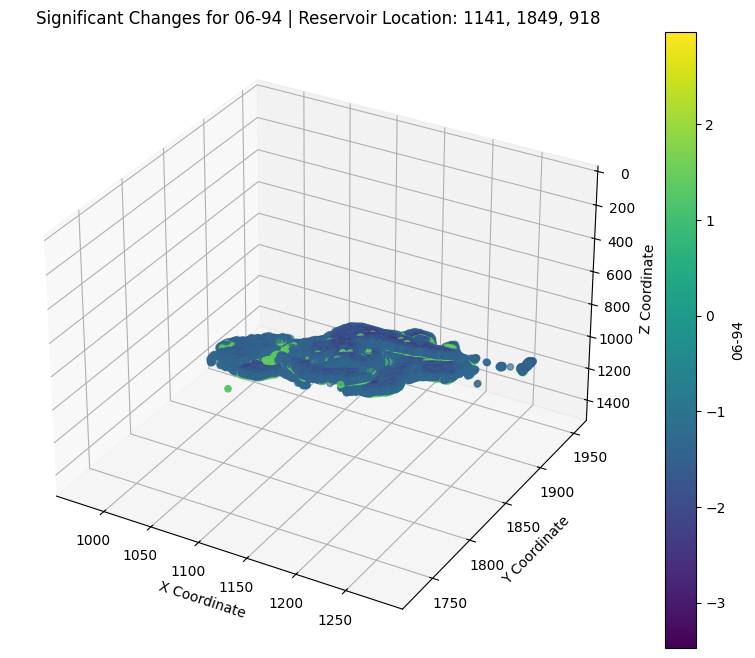

In [6]:
# Define the standard deviation threshold
STD_THRESHOLD = 7.5

# Loop through the difference columns
for year_range in ['01-94', '06-01', '06-94']:
    print(f"Analyzing year range: {year_range}")

    # Calculate the threshold based on the current year range
    threshold = full_data[year_range].std() * STD_THRESHOLD

    # Find significant changes where the absolute difference exceeds the threshold
    significant_changes = full_data[(full_data[year_range].abs() > threshold)].copy()

    # Filter out rows where 'z' is not between the 30th and 70th percentile
    significant_changes = significant_changes[(significant_changes['z'] >= full_data['z'].quantile(0.3)) & 
                                              (significant_changes['z'] <= full_data['z'].quantile(0.7))]
    mean_values = significant_changes.describe().loc['mean']
    mean_x, mean_y, mean_z = int(mean_values.x), int(mean_values.y), int(mean_values.z)
    
    # Initialize figure for plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    # Scatter plot for significant changes with color based on the year range feature
    scatter = ax.scatter(significant_changes['x'], significant_changes['y'], significant_changes['z'],
                         c=significant_changes[year_range], cmap='viridis', marker='o')

    # Customize the plot
    ax.set_title(f'Significant Changes for {year_range} | Reservoir Location: {mean_x}, {mean_y}, {mean_z}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')

    # Set the axes limits
    ax.set_xlim(full_data['x'].min(), full_data['x'].max())
    ax.set_ylim(full_data['y'].min(), full_data['y'].max())
    ax.set_zlim(full_data['z'].min(), full_data['z'].max())
    ax.invert_zaxis()

    # Adding a colorbar to interpret the year range feature values
    colorbar = fig.colorbar(scatter, ax=ax)
    colorbar.set_label(year_range)

    # Show the plot
    plt.show()


Analyzing year range: 01-94


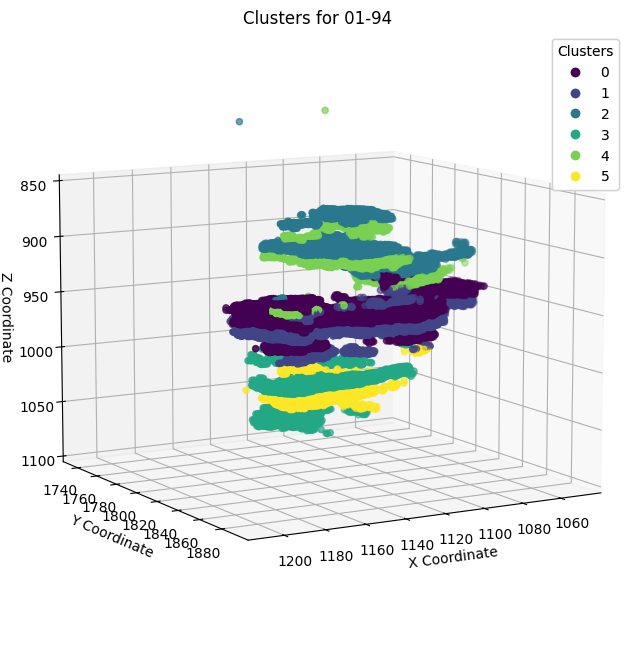

Analyzing year range: 06-01


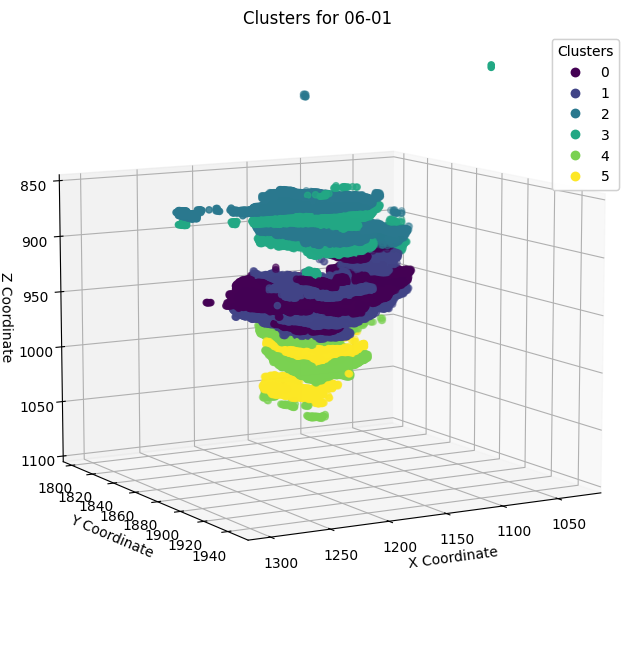

Analyzing year range: 06-94


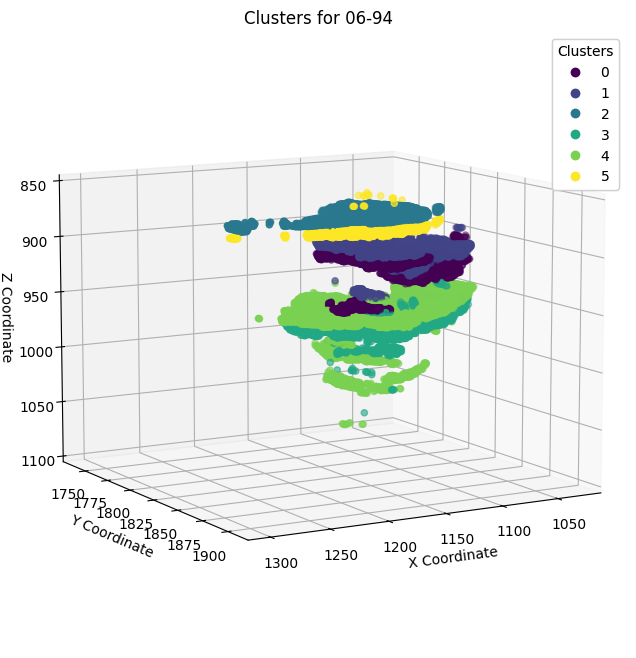

In [26]:

# Define the standard deviation threshold
STD_THRESHOLD = 7.5

# Loop through the difference columns
for year_range in ['01-94', '06-01', '06-94']:
    print(f"Analyzing year range: {year_range}")

    # Calculate the threshold based on the current year range
    threshold = full_data[year_range].std() * STD_THRESHOLD

    # Find significant changes where the absolute difference exceeds the threshold
    significant_changes = full_data[(full_data[year_range].abs() > threshold)].copy()

    # Drop the original year columns as they are not needed for clustering
    significant_changes = significant_changes.drop(['94', '01', '06'], axis=1)

    # Filter out rows where 'z' is not between the 30th and 70th percentile
    significant_changes = significant_changes[(significant_changes['z'] >= full_data['z'].quantile(0.3)) & 
                                              (significant_changes['z'] <= full_data['z'].quantile(0.7))]

    # Scale the data
    scaler = StandardScaler()
    significant_changes_scaled = scaler.fit_transform(significant_changes[['z', year_range]])

    # Cluster the data using k-means
    n_clusters = 6
    kmeans_optimal = KMeans(n_clusters=n_clusters, init='k-means++', random_state=2)
    clusters = kmeans_optimal.fit_predict(significant_changes_scaled)

    # Add the cluster assignment back to the significant_changes DataFrame
    significant_changes['Cluster'] = clusters

    # Initialize figure for plotting
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for different clusters
    scatter = ax.scatter(significant_changes['x'], significant_changes['y'], significant_changes['z'],
                         c=significant_changes['Cluster'], cmap='viridis', marker='o')

    # Customize the plot
    ax.set_title(f'Clusters for {year_range}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')

    # # Set the axes limits
    # ax.set_xlim(full_data['x'].min(), full_data['x'].max())
    # ax.set_ylim(full_data['y'].min(), full_data['y'].max())
    ax.set_zlim(850, 1100)
    ax.invert_zaxis()

    # Add a legend for clusters
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
    ax.add_artist(legend1)
    ax.view_init(elev=10, azim=60)
    plt.show()